In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [2]:
def get_direct_link(shared_link):
    return 'https://drive.google.com/uc?export=download&id=' + shared_link.split('/')[-2]

link = "https://drive.google.com/file/d/1N5HFfTiUx_y-WR-20Zna4eJmy6G7LNgZ/view?usp=drive_link"
direct_link = get_direct_link(link)
df = pd.read_csv(direct_link)

In [3]:
df = df.sort_values(by='Date')

split_index = int(0.75 * len(df))

train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()

test_df.reset_index(drop=True, inplace=True)

print('Fit set rows: '+str(len(train_df)))
print('Test set rows: '+str(len(test_df)))

Fit set rows: 24169
Test set rows: 8057


In [4]:
train_df.Date = pd.to_datetime(train_df.Date, format='%Y-%m-%d')
train_df = train_df.sort_values(by='Date')

test_df.Date = pd.to_datetime(test_df.Date, format='%Y-%m-%d')
test_df = test_df.sort_values(by='Date')

In [5]:
def build_training_data(features):
    x = np.array(train_df[features])
    y = np.array(train_df['outcome'])
    x = sm.add_constant(x)
    x = x.astype(float)
    return x, y

def train_regression(features):
    x, y = build_training_data(features)
    model = sm.OLS(y, x).fit()
    return model.params

def train_model(rank=True, wiki=True):
    features = ['inverse_avg']
    if rank:
        features.append('rankdist')
    if wiki:
        features.append('wikibuzz')
    return train_regression(features)

def model_prob(coef, inv_odds, rankdist=None, wikibuzz=None):
    prob = coef[0] + coef[1] * inv_odds  
    if rankdist is not None:
        prob += coef[2] * rankdist
    if wikibuzz is not None:
        prob += coef[-1] * wikibuzz
    return prob

def kelly(implied_prob, predicted_prob):
    return max(predicted_prob - ((1 - predicted_prob) / ((1 / implied_prob) - 1)), 0)

def profit(stake, implied_prob, outcome):
    return stake * (1 / implied_prob - 1) if outcome == 1 else -stake

def estimate_probabilities(test_data, coef, odds_provider, use_rank=True, use_wiki=True):
    if use_rank and use_wiki:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], row['rankdist'], row['wikibuzz']), axis=1)
    elif use_rank:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], rankdist=row['rankdist']), axis=1)
    elif use_wiki:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], wikibuzz=row['wikibuzz']), axis=1)
    else:
        test_data['est_prob'] = test_data['inverse_avg'].apply(lambda x: model_prob(coef, x))

    return test_data

def display_results(test_data, odds_provider):
    bet_considered = len(test_data[test_data[f'inverse_{odds_provider}'].notna()])
    bets_placed = len(test_data.loc[(test_data["correct_profit"].notna()) & (test_data["correct_profit"] != 0)])
    mean_overround = ((test_data.sort_values(by="match_id")[f"inverse_{odds_provider}"].rolling(2).sum().iloc[1::2].mean() - 1) * 100)
    total_stake = test_data['correct_stake'].sum()
    total_return = test_data['correct_profit'].sum()
    roi = (((total_return + total_stake) / total_stake) - 1) * 100
    
    results = {
        'Bets considered (2 * Matches)': bet_considered,
        'Number of bets placed': bets_placed,
        'Mean overround (%)': mean_overround,
        'Absolute amount bet': total_stake,
        'Absolute return': total_return,
        'ROI (%)': roi
    }
    
    return results

def show_results(test_data, coef, odds_provider, rank=True, wiki=True):
    test_data = estimate_probabilities(test_data, coef, odds_provider, rank, wiki)
    test_data['stake'] = [kelly(a, b) for a, b in zip(test_data[f'inverse_{odds_provider}'], test_data['est_prob'])]
    test_data['profit'] = [profit(a, b, c) for a, b, c in zip(test_data['stake'], test_data[f'inverse_{odds_provider}'], test_data['outcome'])]
    
    test_df['original_stake'] = [kelly(a,b) for a,b in zip(test_df['inverse_{}'.format(odds_provider)], test_df['est_prob'])]
    test_df['original_profit'] = [profit(a,b,c) for a,b,c in zip(test_df['original_stake'],test_df['inverse_{}'.format(odds_provider)],test_df['outcome'])]
    test_df['post-bet_balance'] = (test_df['original_profit'] + 1).cumprod()
    test_df['pre-bet_balance'] = test_df['post-bet_balance'].shift(1)
    test_df['correct_stake'] = test_df['original_stake'] * test_df['pre-bet_balance']
    test_df['correct_profit'] = test_df['original_profit'] * test_df['pre-bet_balance']
    
    results = display_results(test_data, odds_provider)
    print(results)
    return results

def plot_results(test_df):
    test_df['cum_profit'] = test_df['correct_profit'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 6))
    test_df.plot('Date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)

    ax.set_title('Cumulative Profit Over Time', fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)

    ax.tick_params(axis='both', labelsize=12)

    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.show()

def plot_results_save(test_df, filename, title):
    test_df['cum_profit'] = test_df['correct_profit'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 6))
    test_df.plot('Date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)
    
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    
    ax.tick_params(axis='both', labelsize=12)

    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()


{'Bets considered (2 * Matches)': 8057, 'Number of bets placed': 2113, 'Mean overround (%)': 5.328606335910258, 'Absolute amount bet': -112.23858620895875, 'Absolute return': -1.0003938393233542, 'ROI (%)': 0.8913100860526546}


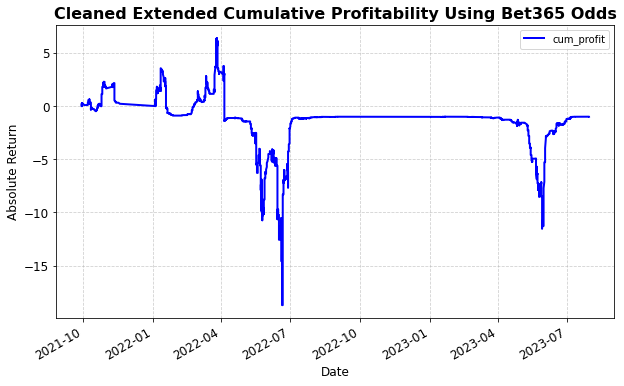

In [6]:
# preferred model on B365
coef = train_model()
show_results(test_df, coef, 'B365')
plot_results_save(test_df, 'clean_tennis_1.png', "Cleaned Extended Cumulative Profitability Using Bet365 Odds")

In [7]:
coef

array([-0.01687679,  0.97916398,  0.00804735, -0.02559683])

In [9]:
test_df.sort_values(by='est_prob')

,match_id,player,Date,Year,rankdist,wikibuzz,inverse_B365,inverse_avg,inverse_best,outcome,est_prob,stake,profit,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
5260,7590,Osorio M.,2023-01-18,2023,0.988095,5.356715,0.076923,0.080192,0.057143,0,-0.067519,0.000000,-0.000000,0.000000,-0.000000,-0.021572,-0.021572,-0.000000,0.000000,-1.021572
7950,7629,Abduraimova N.,2023-07-25,2023,0.994475,2.933186,0.034483,0.042992,0.014925,0,-0.041858,0.000000,-0.000000,0.000000,-0.000000,-0.001616,-0.001616,-0.000000,0.000000,-1.001616
6913,9006,El Allami M.,2023-05-23,2023,0.010404,3.110367,0.047619,0.056022,0.033367,0,-0.041553,0.000000,-0.000000,0.000000,-0.000000,-5.406584,-5.406584,-0.000000,0.000000,-6.406584
2074,4899,Puig M.,2022-04-29,2022,0.116935,5.999846,0.125000,0.132450,0.101010,0,-0.039822,0.000000,-0.000000,0.000000,-0.000000,-0.421191,-0.421191,-0.000000,0.000000,-1.421191
4370,8355,Jeong B.,2022-09-20,2022,0.051178,3.346491,0.038462,0.064935,0.038462,0,-0.038542,0.000000,-0.000000,0.000000,-0.000000,-0.000385,-0.000385,-0.000000,0.000000,-1.000385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3712,920,Anisimova A.,2022-08-09,2022,-0.040135,-4.478682,0.934579,0.943396,0.909091,1,1.021180,1.323749,0.092662,1.323749,0.092662,-0.053674,-0.049122,-0.065025,-0.004552,-1.053674
6903,9006,Rakhimova K.,2023-05-23,2023,-0.010404,-3.110367,0.980392,0.990099,0.980392,1,1.032124,2.638339,0.052767,2.638339,0.052767,-5.646695,-5.363671,-14.151184,-0.283024,-6.646695
4364,8355,Ostapenko J.,2022-09-20,2022,-0.051178,-3.346491,0.990099,0.990099,0.970874,1,1.037840,4.821860,0.048219,4.821860,0.048219,-0.000370,-0.000353,-0.001702,-0.000017,-1.000370
2087,4899,Collins D.,2022-04-29,2022,-0.116935,-5.999846,0.925926,0.925926,0.909091,1,1.042393,1.572299,0.125784,1.572299,0.125784,-0.310251,-0.275587,-0.433305,-0.034664,-1.310251


In [10]:
test_df.loc[test_df.match_id == 7590]

,match_id,player,Date,Year,rankdist,wikibuzz,inverse_B365,inverse_avg,inverse_best,outcome,est_prob,stake,profit,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
5260,7590,Osorio M.,2023-01-18,2023,0.988095,5.356715,0.076923,0.080192,0.057143,0,-0.067519,0.000000,-0.000000,0.000000,-0.000000,-0.021572,-0.021572,-0.000000,0.000000,-1.021572
5248,7590,Swiatek I.,2023-01-18,2023,-0.988095,-5.356715,0.961538,0.970874,0.952381,1,1.062931,2.636211,0.105448,2.636211,0.105448,-0.012084,-0.010931,-0.028817,-0.001153,-1.012084


In [14]:
test_df.sort_values(by='correct_profit', ascending=True)

,match_id,player,Date,Year,rankdist,wikibuzz,inverse_B365,inverse_avg,inverse_best,outcome,est_prob,stake,profit,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
1817,17158,Schmiedlova A.,2022-04-05,2022,-0.009127,-4.056123,0.925926,0.943396,0.917431,0,1.010613,1.143279,-1.143279,1.143279,-1.143279,-0.399939,2.791331,3.191270,-3.191270,-1.399939
1724,10668,Azarenka V.,2022-03-27,2022,-0.058916,-3.538451,0.819672,0.826446,0.781250,0,0.882449,0.348124,-0.348124,0.348124,-0.348124,4.638152,7.115086,2.476934,-2.476934,3.638152
2842,11950,Kostyuk M.,2022-06-19,2022,0.006950,-4.316583,0.400000,0.396825,0.355872,1,0.482227,0.137045,0.205568,0.137045,0.205568,-12.724519,-10.554794,-1.446483,-2.169725,-13.724519
2907,13544,Kvitova P.,2022-06-21,2022,-0.021505,-3.974640,0.526316,0.534759,0.505051,1,0.608305,0.173089,0.155780,0.173089,0.155780,-14.629141,-12.657372,-2.190855,-1.971769,-15.629141
889,10938,Fernandez L.A.,2022-01-18,2022,-0.034148,-3.478774,0.909091,0.917431,0.884956,0,0.970210,0.672305,-0.672305,0.672305,-0.672305,0.909249,2.774683,1.865434,-1.865434,-0.090751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2931,2036,Sakkari M.,2022-06-21,2022,-0.172222,-2.349740,0.800000,0.800000,0.740741,0,0.825214,0.126072,-0.126072,0.126072,-0.126072,-12.684970,-14.514886,-1.829916,1.829916,-13.684970
7103,13727,Ostapenko J.,2023-05-31,2023,0.002865,-2.834851,0.714286,0.729927,0.714286,0,0.770428,0.196497,-0.196497,0.196497,-0.196497,-8.257494,-10.276866,-2.019372,2.019372,-9.257494
2918,9741,Pliskovax K.,2022-06-21,2022,-0.134983,-1.908789,0.694444,0.714286,0.689655,0,0.730299,0.117341,-0.117341,0.117341,-0.117341,-15.646470,-17.726524,-2.080054,2.080054,-16.646470
2911,8460,Badosa P.,2022-06-21,2022,-0.244083,-4.718745,0.819672,0.826446,0.800000,0,0.911170,0.507399,-0.507399,0.507399,-0.507399,-7.314651,-14.849038,-7.534386,7.534386,-8.314651


{'Bets considered (2 * Matches)': 8057, 'Number of bets placed': 3988, 'Mean overround (%)': -0.0874559108306916, 'Absolute amount bet': -1292305.5442114195, 'Absolute return': -0.9809708439962321, 'ROI (%)': 7.590858432937608e-05}


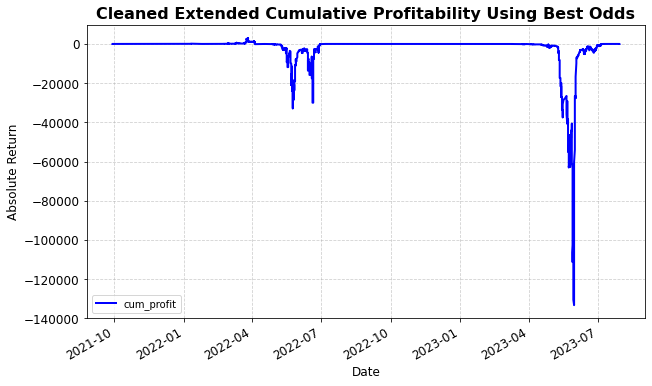

In [16]:
# preferred model on best
coef = train_model()
show_results(test_df, coef, 'best')
plot_results_save(test_df, 'clean_tennis_2.png', "Cleaned Extended Cumulative Profitability Using Best Odds")